# VERIFICATION
In this notebook, we will validate the behavior of all functions to ensure they work as expected. We will also verify what can be simplified or neglected during the dimensioning process (handled in a separate notebook).

In [79]:
# 3rd Party Libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from IPython.display import display, Math

# Internal Libraries
import functions as f
import nuclei_func as nf
from functions import Material_Proprieties, ThermoHydraulicSpecs, GeometryData, DimensioningData, Temperature_Map

## Input Data

All material proprietes (Fuel, Helium, Cladding and Coolant) are saved in a custom defined class to avoid repeatedly passing many parameters to functions, reducing complexity and improving code readability and maintainability.

In [80]:
# Material: Cladding
# 15-15, Ti stabilized, cold worked stainless steel
Cladding_Proprieties = Material_Proprieties(
    Elements=["Cr", "Ni", "Mo", "Mn", "Si", "Ti", "C", "B [ppm]"],
    Qualities=[15, 15, 1.5, 1.5, 0.9, 0.4, 0.09, 60],
    Density=lambda eth: 7900 * (1 + eth)**-3,  # kg/m^3
    Thermal_Conductivity=lambda t: 13.95 + 0.01163 * t,  # W/m K
    Emissivity = 0.32, # -
    Thermal_Expansion_Coeff=lambda t: -3.101e-4 + 1.545e-5 * t + 2.75e-9 * t**2,  # 1/°C
    Specific_Heat=500,  # Approximate value in J/kg K for steel
    Melting_Temperature=1673,  # K
    
    Youngs_Modulus=lambda t: 202.7 - 0.08167 * t,  # GPa
    Poissons_Ratio=lambda t: 0.277 + 6e-5 * t,  # Dimensionless
    Yield_Stress=lambda t: 555.5 - 0.25 * t if t < 600 else (405.5 - 0.775 * (t - 600) if t < 1000 else 345.5 - 0.25 * t),  # MPa
    Ultimate_Tensile_Strength=lambda t: 700 - 0.3125 * t if t < 600 else (512.5 - 0.969 * (t - 600) if t < 1000 else 437.5 - 0.3125 * t),  # MPa
)

# Material: Fuel
# Homogeneous MOX fuel

# Qualities have to be converted from weight to molar (won't change in hot condition):
mol_qual = nf.w2mol([0.711, 0.29], [235 + 2*16, 239 + 2*16])  # UO2, PuO2

Fuel_Proprieties = Material_Proprieties(
    Elements=["U-235", "U-238", "O-16", "Pu"],
    Qualities=[mol_qual[0] * (1 - mol_qual[1]), (1 - mol_qual[0]) * (1 - mol_qual[1]), 2, mol_qual[1]], # Molar fractions
    Theoretical_Density=11.31, # g/cm^3
    Percent_of_Theoretical_Density = 94.5, # %
    Molar_Mass=[235.0439299, 238.05078826, 15.99491461956, 244.064204],  # g/mol
    Thermal_Conductivity=lambda k_inf, beta: 1.755 + (k_inf - 1.755) * math.exp(-beta),  # W/m K
    Emissivity = 0.79, # -
    Thermal_Expansion_Coeff=1.2e-5,  # 1/°C
    Specific_Heat=270,  # Approximate value in J/kg K for MOX fuel
    Melting_Temperature=lambda pu, x, beta: 2964.92 + ((3147 - 364.85 * pu - 1014.15 * x) - 2964.92) * math.exp(-beta/41.01),  # K
    Oxigen_to_metal_ratio = 1.957, # -
    Grain_diameter = 10 * 1e-6,  # m
    Youngs_Modulus=lambda t, p: (22.43 * 10**4 - 31.19 * t) * (1 - 2.6 * p),  # MPa
    Poissons_Ratio=0.32,  # Dimensionless
)

# Material: Coolant (Sodium)
Coolant_Proprieties = Material_Proprieties(
    Elements=["Na"],
    Qualities=[1],
    Density=lambda t: 954.1579 + ((t-273) * 9/5 +32) *( ((t-273) * 9/5 +32) * ((((t-273) * 9/5 +32) * 0.9667e-9 - 0.46e-5)) - 0.1273534),  # kg/m^3 (t * 9/5 +32) is the convertion from C to K to F
    Viscosity=lambda t: (math.exp(813.9 / t -2.530 ))/1000,  # Pa s
    Thermal_Conductivity=lambda t: 110 - 0.0648 * t + 1.16e-5 * t**2,  # W/m K
    Specific_Heat=lambda t: 1608 - 0.7481 * t + 3.929e-4 * t**2,  # J/kg K
    
    Melting_Temperature=98,  # °C
    Boiling_Temperature=882,  # °C
    Nusselt_Number=lambda pe: 7 + 0.025 * pe**0.8
)

# Material: Helium (Filling Gas)
Helium_Proprieties = Material_Proprieties(
    Elements=["He"],
    Qualities=[1],
    Density=0.1786,  # kg/m^3 at STP
    Thermal_Conductivity=lambda t: 15.8e-4 * t**0.79,  # W/m K
    Specific_Heat=5193,  # J/kg K at constant pressure
    Thermal_Expansion_Coeff=3.66e-3  # Approximate value for helium in 1/°C
)


Other data is saved as common variables

In [81]:
Geometrical_Data = GeometryData(
    fuel_outer_diameter=5.42 * 1e-3,  # m - GIVEN
    fuel_inner_diameter=0.00 * 1e-3,  # m
    cladding_outer_diameter=6.55 * 1e-3,  # m - GIVEN
    thickness_cladding=100 * 1e-6, # m
    pin_pitch=8.275 * 1e-3,  # m
    h_values = np.linspace(0, 0.85, 10), # m
    fuel_pellet_height = 7e-3, # m
    fuel_roughness = 2e-6, # m
    cladding_roughness = 1e-6 # m
)

# Example of initializing Thermo-Hydraulic specifications
heights_of_slice_centre = [42.5, 127.5, 212.5, 297.5, 382.5, 467.5, 552.5, 637.5, 722.5, 807.5] # mm
ThermoHydraulics = ThermoHydraulicSpecs(
    coolant_inlet_temp=395 + 273,  # K
    coolant_inlet_pressure=1e5,  # Pa
    coolant_mass_flow_rate=0.049,  # kg/s
    q_linear_avg = 38.7e3,  #W/m,
    uptime = 360 * 24 * 3600,  # s
    h_peak_factor = [h * 1e-3 for h in heights_of_slice_centre],  # m
    peak_factors = [0.572, 0.737, 0.868, 0.958, 1, 0.983, 0.912, 0.802, 0.658, 0.498],
    neutron_flux_peak = 6.1e15  # Neutron Flux (> 100 keV) (10^15 n cm^-2 s^-1) at Peak Power Node    
)

vars = DimensioningData(
    filling_gas_pressure = 1e5,  # Pa
    filling_gas_temperature = 20,  # °C
    temperature_map = ''
)

# Data for Axial Nodalization of the Fuel Pin



Verification parameters that will be needed for dimensioning

In [82]:
# Data for Indicative Design Limits
max_fuel_temp = 2600  # °C
max_cladding_temp = 650  # °C
max_plenum_pressure = 5  # MPa
max_cladding_plastic_strain = 0.5  # %
max_cladding_swelling = 3  # %
max_coolant_velocity = 8  # m/s

## Thermal - Hydraulics Analysis

In [83]:
Computing_Temperature = ThermoHydraulics.coolant_inlet_temp  # K
display(Math(r'T_{\text{Computing}} = %s \, \text{K}' % Computing_Temperature))

<IPython.core.display.Math object>

In [84]:
#Preliminary check of coolant properties

density = Coolant_Proprieties.Density(Computing_Temperature)
viscosity = Coolant_Proprieties.Viscosity(Computing_Temperature)
thermal_conductivity = Coolant_Proprieties.Thermal_Conductivity(Computing_Temperature)
c_p = Coolant_Proprieties.Specific_Heat(Computing_Temperature)

display(Math(r'\rho_{coolant} =' + f'{density:.2f}' + r'\text{ kg/m}^3' ))
display(Math(r'\mu_{coolant} =' + f'{viscosity*1000:.2f}' + r'\text{ mPa s}' ))
display(Math(r'k_{coolant} =' + f'{thermal_conductivity:.2f}' + r'\text{ W/m K}' ))
display(Math(r'c_p =' + f'{c_p:.2f}' + r'\text{ J/kg K}' ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [85]:
# Velocity and Passage Area Calculation
# To be modified with a proper evaluation

velocity, passage_area, d_h = f.hydraulic_flow(ThermoHydraulics, Geometrical_Data, Coolant_Proprieties, Computing_Temperature)

display(Math(r'v_{coolant} =' + f'{velocity:.2f}' + r'\text{ m/s}' ))
display(Math(r'A_{passage} =' + f'{passage_area*1e6:.2f}' + r'\text{ mm}^2' ))
display(Math(r'D_{hydr} =' + f'{d_h*1e3:.2f}' + r'\text{ mm}'))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [86]:
# Computing the Heat Transfer Coefficient between the Coolant and the cladding
htc_coolant, reynolds, prandtl, peclet, nusselt, d_h = f.heat_trans_coefficient(Geometrical_Data, ThermoHydraulics, Coolant_Proprieties, Computing_Temperature)
# Display the heat transfer coefficient
display(Math(r'\alpha_{cladding - coolant} =' + f'{htc_coolant*1e-3:.2f}' + r'\text{ kW/m}^2\text{K}'))
display(Math(r'Re =' + f'{reynolds:.2f}'))
display(Math(r'Pe =' + f'{peclet:.2f}' ))
display(Math(r'Pr =' + f'{prandtl:.4f}' ))
display(Math(r'D_{h} =' + f'{d_h*1e3:.2f}' + r'\text{ mm}' ))
display(Math(r'Nu =' + f'{nusselt:.2f}' ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Axial Power Profile

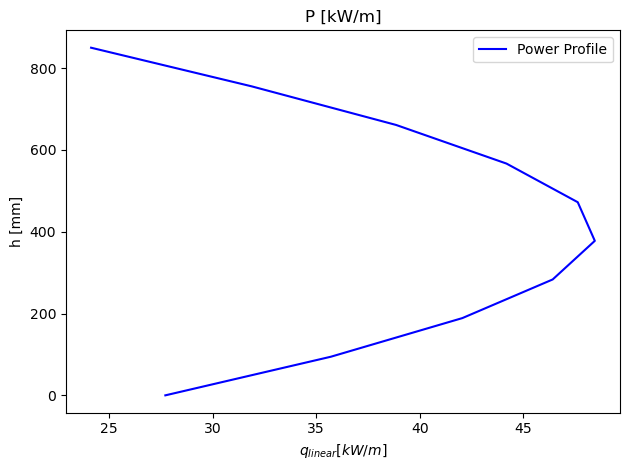

In [87]:
q_values = [f.power_profile(h, ThermoHydraulics) for h in Geometrical_Data.h_values]

# Create a figure with one subplot
fig, (power1) = plt.subplots(1)

# Plot the power profile
power1.plot(np.array(q_values)*1e-3, np.array(Geometrical_Data.h_values)*1e3, label='Power Profile', color='blue')

# Set title and axis labels
power1.set_title(r'P [kW/m]')
power1.set_xlabel(r'$q_{linear} [kW/m]$')
power1.set_ylabel(r'h [mm]')

# Add legend to the plot
power1.legend()

# Adjusts spacing between the plots
plt.tight_layout()

# Show the figure
plt.show()

### Radial temperature profile
Thermal resistances  
Fuel - Helium (gap) - Cladding - Coolant

In [88]:
R_coolant = f.thermal_resistance_coolant(Geometrical_Data, htc_coolant)
display(Math(r'R_{coolant} =' + f'{R_coolant:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [89]:
R_cladding = f.thermal_resistance_cladding(Geometrical_Data, Cladding_Proprieties, Computing_Temperature)
display(Math(r'R_{cladding} =' + f'{R_cladding:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [90]:
R_gap = f.thermal_resistance_gap(
    Geometrical_Data, Helium_Proprieties, Fuel_Proprieties, Cladding_Proprieties)

# Just to print a value
Temperature_Fuel_Out = Computing_Temperature # K
Temperature_Cladding_In = Computing_Temperature
Temperature_Gas = (Temperature_Fuel_Out + Temperature_Cladding_In) / 2
R_gap_eval = R_gap(Temperature_Gas, Temperature_Fuel_Out)
display(Math(r'R_{gap} =' + f'{R_gap_eval:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [91]:
Temperature_Fuel = Computing_Temperature
Burnup = 0

R_fuel = f.thermal_resistance_fuel(Burnup, Fuel_Proprieties) # Outputs a lambda function
R_fuel_eval = R_fuel(Temperature_Fuel) # Evaluate the lambda function for display
display(Math(r'R_{fuel} =' + f'{R_fuel_eval:.6f}' + r'\frac{m \cdot K}{W}'))

<IPython.core.display.Math object>

In [92]:
class th_resistances:
    def __init__(self, R_fuel, R_gap, R_cladding, R_coolant):
        self.Fuel = R_fuel
        self.Gap = R_gap
        self.Cladding = R_cladding
        self.Coolant = R_coolant

Resistances = th_resistances(R_fuel, R_gap, R_cladding, R_coolant)

### Temperature Profile


3D plot computes all the points

In [93]:
# Pre-compute the temperature matrix using the plot function
r_coolant_infinity = Geometrical_Data.cladding_outer_diameter / 2 + Geometrical_Data.pin_pitch / np.sqrt(3)
r_coolant_cladding = Geometrical_Data.cladding_outer_diameter / 2
r_cladding_gap = Geometrical_Data.cladding_outer_diameter / 2 - Geometrical_Data.thickness_cladding
r_gap_fuel = Geometrical_Data.fuel_outer_diameter / 2
r_end = Geometrical_Data.fuel_inner_diameter / 2

r_coolant = np.linspace(r_coolant_infinity, r_coolant_cladding, 2)[0:-1]
r_cladding = np.linspace(r_coolant_cladding, r_cladding_gap, 2)[0:-1]
r_gap = np.linspace(r_cladding_gap, r_gap_fuel,5)[0:-1]
r_fuel = np.linspace(r_gap_fuel, r_end, 10)

r_plot = np.concatenate((r_coolant, r_cladding, r_gap, r_fuel))
# print(r_plot)
print(len(r_plot))
# r_plot = np.linspace(Geometrical_Data.cladding_outer_diameter/2 + 3e-3, 0, 100)

# 3D plot of the temperature profile
T_fuel_out = 1500 # K (Initial guess)
vars.T_map = f.temperature_profile_3D(r_plot, Resistances, Coolant_Proprieties, ThermoHydraulics, Geometrical_Data, T_fuel_out, Burnup)

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=vars.T_map.T, x=vars.T_map.r*1e3, y=vars.T_map.h*1e3, colorscale='Viridis')])

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Radius (mm)',
        yaxis_title='Height (mm)',
        zaxis_title='Temperature (K)'
    ),
    title="3D Temperature Profile vs. Radius and Height (q_values)",
    autosize=False,
    width=800,
    height=800
)

# Show the plot
fig.show()
    

16


We can get the temperature value at any point

In [94]:
# Get temperature at a specific point (height and radius) using pre-computed data
height = 0e-3 # mm
radius = 8e-3 # mm
temperature_at_point = f.get_temperature_at_point(height, radius, vars.T_map)
print(f"Temperature at height {height*1e3} mm and radius {radius*1e3} mm: {temperature_at_point:.2f} K")

Temperature at height 0.0 mm and radius 8.0 mm: 688.81 K


We can plot the radial temperature profile

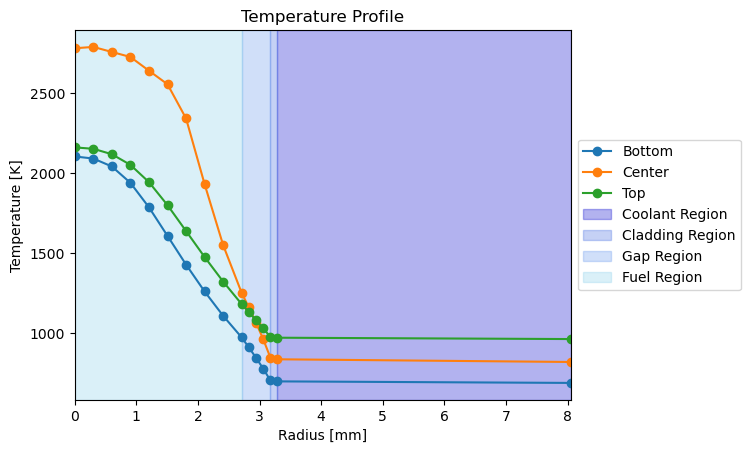

In [95]:
# 2D plot of the temperature profile
temp_plot_bottom = [f.get_temperature_at_point(0, r, vars.T_map) for r in r_plot]
temp_plot_center = [f.get_temperature_at_point(0.425, r, vars.T_map) for r in r_plot]
temp_plot_top = [f.get_temperature_at_point(0.850, r, vars.T_map) for r in r_plot]

# Create plot
plt.plot(r_plot * 1e3, temp_plot_bottom, label='Bottom', marker='o')
plt.plot(r_plot * 1e3, temp_plot_center, label='Center', marker='o')
plt.plot(r_plot * 1e3, temp_plot_top, label='Top', marker='o')

r_0 = Geometrical_Data.fuel_inner_diameter/2 * 1e3
r_1 = Geometrical_Data.fuel_outer_diameter/2 * 1e3
r_2 = Geometrical_Data.cladding_outer_diameter/2 * 1e3 - Geometrical_Data.thickness_cladding * 1e3
r_3 = Geometrical_Data.cladding_outer_diameter/2 * 1e3 
r_4 = r_plot[0]*1e3

# Add shading to different regions
colors = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEEB']
plt.axvspan(r_3, r_4, color=colors[1], alpha=0.3, label='Coolant Region')
plt.axvspan(r_2, r_3, color=colors[2], alpha=0.3, label='Cladding Region')
plt.axvspan(r_1, r_2, color=colors[3], alpha=0.3, label='Gap Region')
plt.axvspan(r_0, r_1, color=colors[4], alpha=0.3, label='Fuel Region')

# Set title and axis labels
plt.title('Temperature Profile')
plt.xlabel('Radius [mm]')
plt.xlim(r_0, r_4)
plt.ylabel('Temperature [K]')

# Add legend to the plot
plt.legend()

# Put the legend out of the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the figure
plt.show()

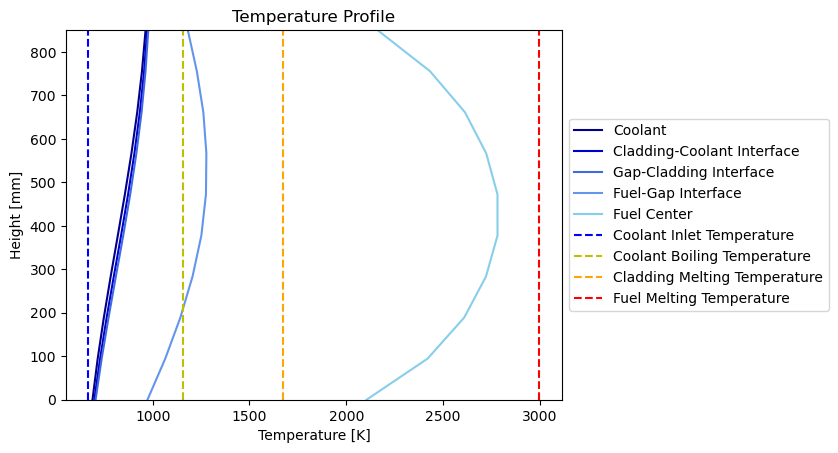

In [118]:
# 2D plot of the temperature profiles along the axial direction
r_to_plot = [vars.T_map.r[-1],
             Geometrical_Data.cladding_outer_diameter/2,
             Geometrical_Data.cladding_outer_diameter / 2 - Geometrical_Data.thickness_cladding,
             Geometrical_Data.fuel_outer_diameter/2,
             Geometrical_Data.fuel_inner_diameter/2]

labels = ['Coolant', 
          'Cladding-Coolant Interface', 
          'Gap-Cladding Interface', 
          'Fuel-Gap Interface', 
          'Fuel Center']

colors = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEEB']
h_vals = Geometrical_Data.h_values

to_plot = 5
for i in range(to_plot):
    temp_axial = [f.get_temperature_at_point(h, r_to_plot[i], vars.T_map) for h in h_vals]
    plt.plot(temp_axial, h_vals*1e3, label=labels[i], color=colors[i])

# Plot a line at the coolant inlet temperature
plt.axvline(x=ThermoHydraulics.coolant_inlet_temp, color='b', linestyle='--', label='Coolant Inlet Temperature')

# Plot a line at the coolant boling temperature
plt.axvline(x=Coolant_Proprieties.Boiling_Temperature + 273, color='y', linestyle='--', label='Coolant Boiling Temperature')

# Plot a line at the cladding melting temperature
plt.axvline(x=Cladding_Proprieties.Melting_Temperature, color='orange', linestyle='--', label='Cladding Melting Temperature')

# Plot a line at the fuel melting temperature
stechiometry = 2 - Fuel_Proprieties.Oxigen_to_metal_ratio
pu_weight = 0.29
plt.axvline(x=Fuel_Proprieties.Melting_Temperature(pu_weight,stechiometry,Burnup), color='r', linestyle='--', label='Fuel Melting Temperature')

# Set title and axis labels
plt.title('Temperature Profile')
plt.ylabel('Height [mm]')
plt.ylim(0, 850)
plt.xlabel('Temperature [K]')

# Put the legend outside the plot
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the figure
plt.show()

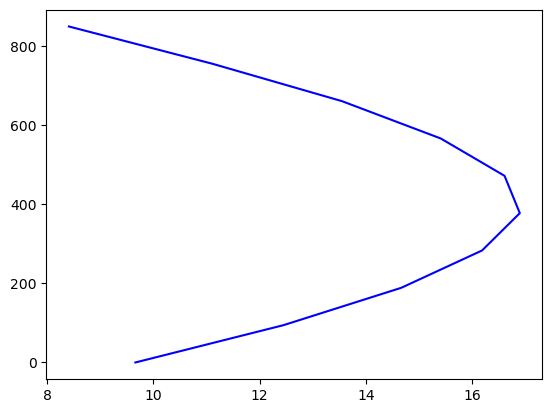

In [97]:
# plot the difference between the coolant profile and the cladding profile
temp_coolant = [-f.get_temperature_at_point(h, r_to_plot[0], vars.T_map) + f.get_temperature_at_point(h, r_to_plot[1], vars.T_map) for h in h_vals]

plt.plot(temp_coolant, h_vals*1e3, label='Coolant', color='blue')
plt.show()

## THERMAL EXPANSION

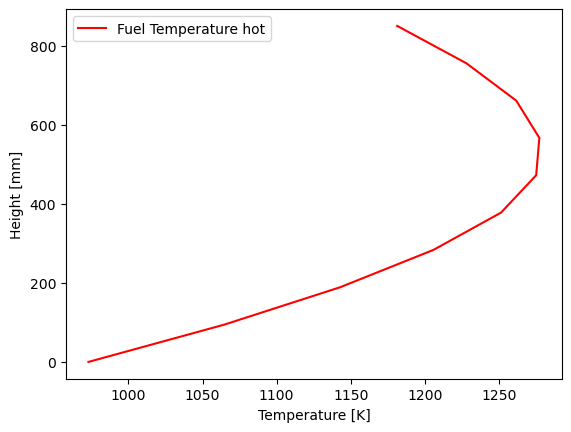

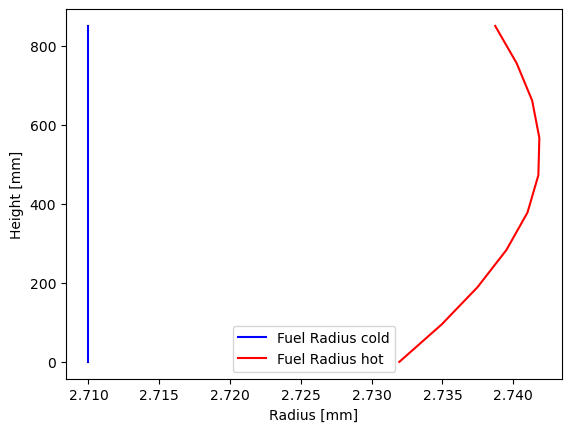

In [98]:
# Find the outer radius of the fuel in hot geometry

R_fuel_hot, R_init_fuel, T_hot_fuel = f.cold_to_hot_fuel(Fuel_Proprieties, Geometrical_Data, vars, h_vals)

# Plot axial temperature profile of fuel

plt.figure()
plt.plot(T_hot_fuel, h_vals * 1e3, label='Fuel Temperature hot', color='red')
plt.ylabel('Height [mm]')
plt.xlabel('Temperature [K]')
plt.legend()
plt.show()


# Plot axial profile of the thermal expansion with respect to the cold fuel radius

plt.figure()
plt.plot(np.array(R_init_fuel) * 1e3, h_vals * 1e3, label='Fuel Radius cold', color='blue')
plt.plot(np.array(R_fuel_hot) * 1e3, h_vals * 1e3, label='Fuel Radius hot', color='red')
plt.xlabel('Radius [mm]')
plt.ylabel('Height [mm]')
plt.legend()
plt.show()


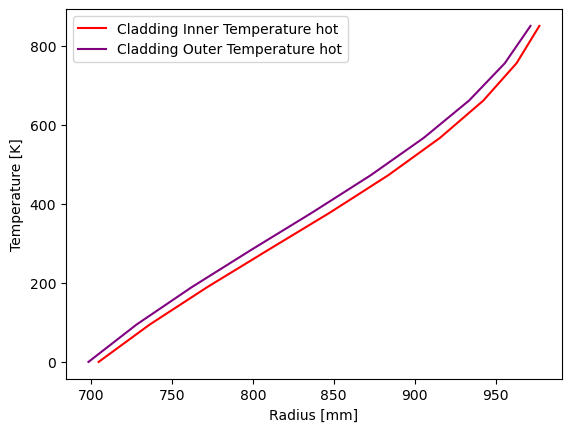

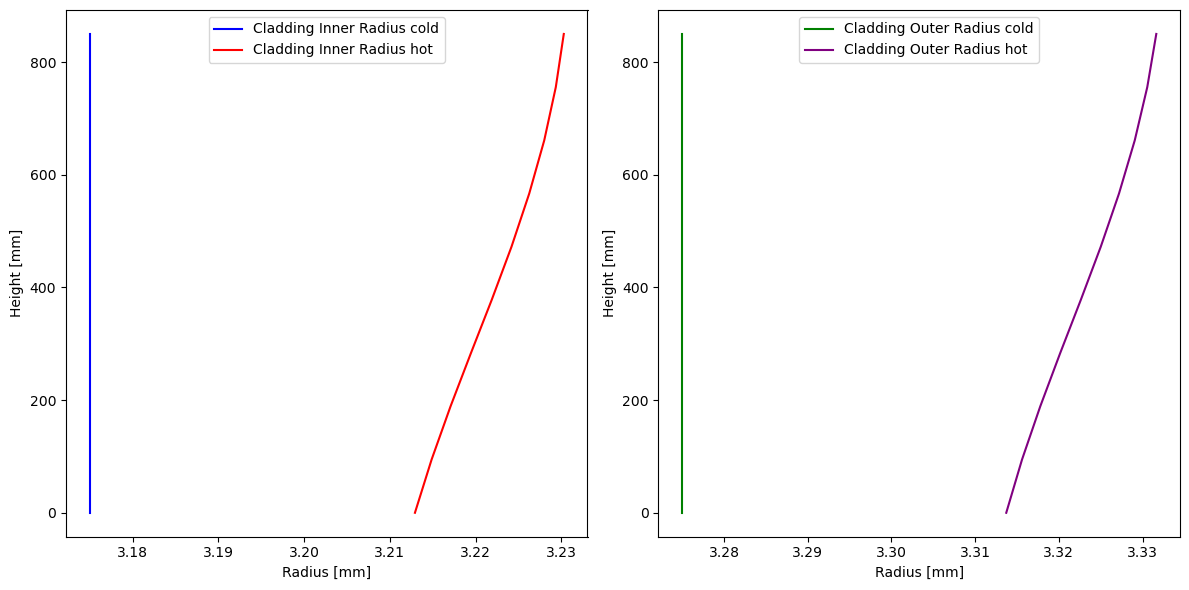

In [99]:
# Find the inner and outer radius of the cladding in hot geometry

R_clad_hot_in, R_init_clad_in, T_hot_clad_in = f.cold_to_hot_clad(Cladding_Proprieties, Geometrical_Data, vars, h_vals, flag = 'inner')
R_clad_hot_out, R_init_clad_out, T_hot_clad_out = f.cold_to_hot_clad(Cladding_Proprieties, Geometrical_Data, vars, h_vals, flag = 'outer')

# Plot axial temperature profile of cladding

plt.figure()
plt.plot(T_hot_clad_in, h_vals * 1e3, label='Cladding Inner Temperature hot', color='red')
plt.plot(T_hot_clad_out, h_vals * 1e3, label='Cladding Outer Temperature hot', color='purple')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.show()


# Plot axial profile of the thermal expansion with respect to the cold caldding radius

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the inner radius of the cladding
ax1.plot(np.array(R_init_clad_in) * 1e3, h_vals * 1e3, label='Cladding Inner Radius cold', color='blue')
ax1.plot(np.array(R_clad_hot_in) * 1e3, h_vals * 1e3, label='Cladding Inner Radius hot', color='red')
ax1.set_xlabel('Radius [mm]')
ax1.set_ylabel('Height [mm]')
ax1.legend()

# Plot the outer radius of the cladding
ax2.plot(np.array(R_init_clad_out) * 1e3, h_vals * 1e3, label='Cladding Outer Radius cold', color='green')
ax2.plot(np.array(R_clad_hot_out) * 1e3, h_vals * 1e3, label='Cladding Outer Radius hot', color='purple')
ax2.set_xlabel('Radius [mm]')
ax2.set_ylabel('Height [mm]')
ax2.legend()

plt.tight_layout()
plt.show()


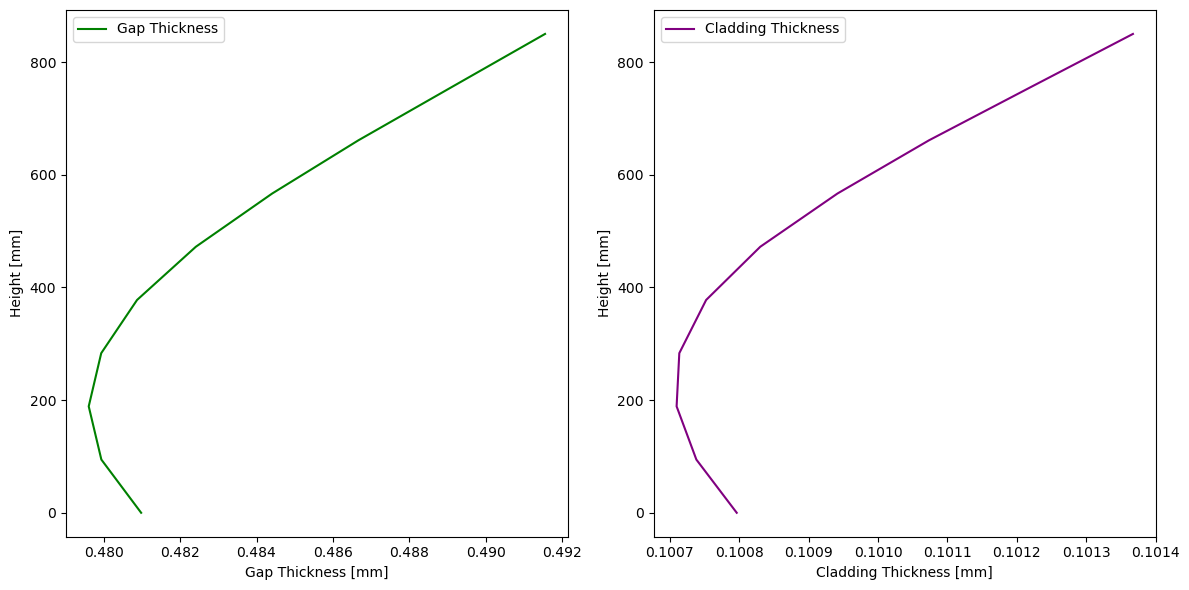

In [100]:
# Plot the gap thickness

gap_thickness = np.array(R_clad_hot_in)-np.array(R_fuel_hot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gap thickness
ax1.plot(gap_thickness * 1e3, h_vals * 1e3, label='Gap Thickness', color='green')
ax1.set_xlabel('Gap Thickness [mm]')
ax1.set_ylabel('Height [mm]')
ax1.legend()

# Plot the cladding thickness
clad_thickness = np.array(R_clad_hot_out) - np.array(R_clad_hot_in)
ax2.plot(clad_thickness * 1e3, h_vals * 1e3, label='Cladding Thickness', color='purple')
ax2.set_xlabel('Cladding Thickness [mm]')
ax2.set_ylabel('Height [mm]')
ax2.legend()

plt.tight_layout()
plt.show()


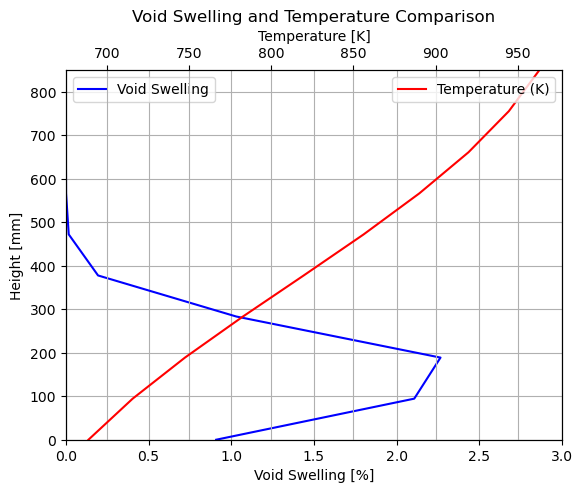

In [101]:
# Find the outer radius of the fuel in hot geometry
void_swell = f.void_swelling(vars.T_map, Geometrical_Data, ThermoHydraulics)
# Calculate void swelling and average temperature
void_swell = np.array(void_swell)
avg_temp = np.mean(vars.T_map.T[:, 0])
y_axis = vars.T_map.h[:, 0] * 1e3

# Create the main plot for Void Swelling
fig, ax1 = plt.subplots()

# Plot Void Swelling
ax1.plot(void_swell, y_axis, label='Void Swelling', color='blue')
ax1.set_xlabel('Void Swelling [%]')
ax1.set_ylabel('Height [mm]')
ax1.grid(True)
ax1.set_xlim(0, 3)

# Create a secondary x-axis sharing the same y-axis for Temperature
ax2 = ax1.twiny()
ax2.plot(vars.T_map.T[:, 0], y_axis, label=f'Temperature (K)', color='red')
ax2.set_xlabel('Temperature [K]')
ax2.grid(True)
# ax2.set_xlim(min(vars.T_map.T[:, 0]), max(vars.T_map.T[:, 0]))

# Add the legend and title
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Void Swelling and Temperature Comparison')
plt.ylim(0, 850)
# plt.axvline((Cladding_Proprieties.Melting_Temperature) * 0.4, color='orange', linestyle='--', label='30% Melting Temperature')
# plt.axvline(Cladding_Proprieties.Melting_Temperature * 0.6, color='orange', linestyle='--', label='60% Melting Temperature')

# Show the plot
plt.show()


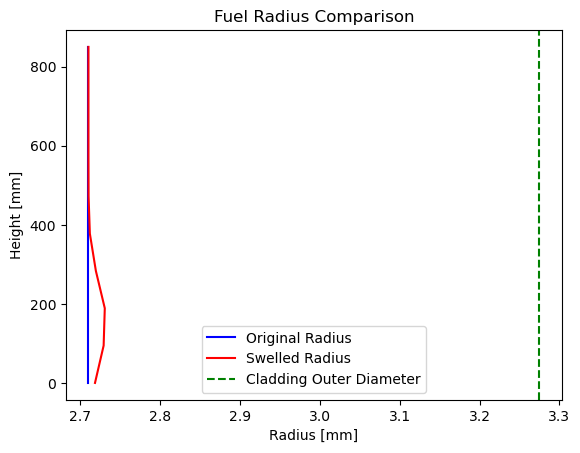

In [102]:
void_swell = f.void_swelling(vars.T_map, Geometrical_Data, ThermoHydraulics)
radius_before = Geometrical_Data.fuel_outer_diameter / 2
radius_swelled = [radius_before * (1 + 1/3*swell/100) for swell in void_swell]

# Plot comparison of the original and swelled fuel radius
plt.plot([radius_before*1e3] * 10, y_axis, label='Original Radius', color='blue')
plt.plot(np.array(radius_swelled) * 1e3, y_axis, label='Swelled Radius', color='red')
plt.axvline(Geometrical_Data.cladding_outer_diameter / 2 * 1e3, color='green', linestyle='--', label='Cladding Outer Diameter')
plt.xlabel('Radius [mm]')
plt.ylabel('Height [mm]')
plt.title('Fuel Radius Comparison')
plt.legend()


# Void Fromation and Fuel Restructuring

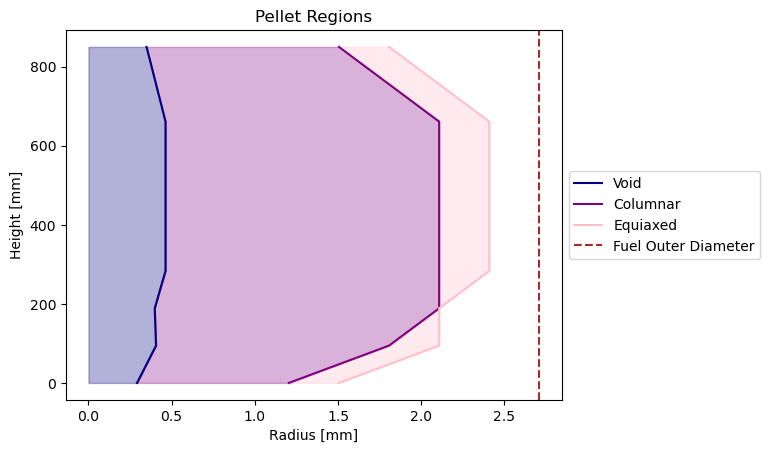

In [103]:
r_col = f.get_radius_at_temperature(1800, vars.T_map)
r_eq = f.get_radius_at_temperature(1600, vars.T_map)
r_void = f.get_R_void(Fuel_Proprieties, r_col, r_eq)


# plot the radius profile versus height
plt.plot(np.array(r_void)*1e3, np.array(vars.T_map.h[:,0])*1e3, color='navy', label='Void')
plt.plot(np.array(r_col)*1e3, np.array(vars.T_map.h[:,0])*1e3, color='purple', label='Columnar')
plt.plot(np.array(r_eq)*1e3, np.array(vars.T_map.h[:,0])*1e3, color='pink', label='Equiaxed')

plt.axvline(x=Geometrical_Data.fuel_outer_diameter/2 * 1e3, color='brown', linestyle='--', label='Fuel Outer Diameter')

plt.title('Pellet Regions')
plt.xlabel('Radius [mm]')
plt.ylabel('Height [mm]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.fill_betweenx(np.array(vars.T_map.h[:,0])*1e3, 0, np.array(r_void)*1e3, color='navy', alpha=0.3)
plt.fill_betweenx(np.array(vars.T_map.h[:,0])*1e3, np.array(r_void)*1e3, np.array(r_col)*1e3, color='purple', alpha=0.3)
plt.fill_betweenx(np.array(vars.T_map.h[:,0])*1e3, np.array(r_col)*1e3, np.array(r_eq)*1e3, color='pink', alpha=0.3)

plt.show()

# Fission Gas Behaviour
We start by evaluating the general expression for the fission product concentration as a function of Burnup

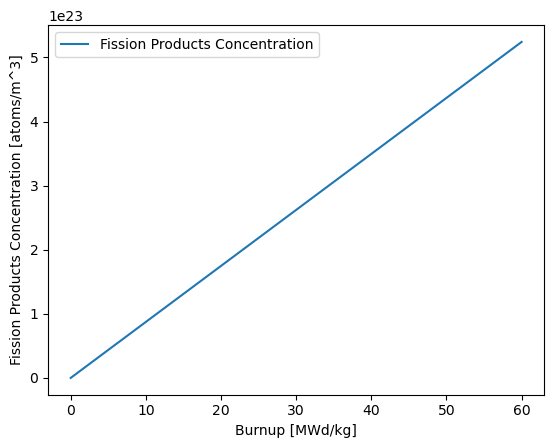

In [104]:
# General expression for fission products' concentration, change parameters as preferred

FP_yield = 0.3 # fission products yield for Xe + Kr
Energy_per_fission = 203.89 * 1.6e-13 # J/fission


# function: Burnup in MWd/kg and Energy per fission in MWd/fission!
FP_concentration = lambda Burnup: (FP_yield * Fuel_Proprieties.Density / (Energy_per_fission * 2.7e-10/24)) * Burnup

# Plot the fission products' concentration
burnup_vals = np.linspace(0, 60, 100)
FP_vals = FP_concentration(burnup_vals)

plt.plot(burnup_vals, FP_vals, label='Fission Products Concentration')
plt.xlabel('Burnup [MWd/kg]')
plt.ylabel('Fission Products Concentration [atoms/m^3]')
plt.legend()
plt.show()



Now we work on the Rate theory equations

In [105]:
#### define the various parameters for the Rate theory equations, good after the INCUBATION TIME

# size of grain
a = 10e-6 # m

### compute the average fission rate in [fissions/m^3 s]

# fission cross sections (see file ""Useful Data.xlsx"")
sigma_235 = 1.047756375 # barn
sigma_238 = 0.55801001 # barn
sigma_pu = 1.689844625 # barn

molar_mass = nf.mixture(Fuel_Proprieties.Molar_Mass, Fuel_Proprieties.Qualities) # g/mol

macro_235 = nf.macro(sigma_235, Fuel_Proprieties.Density, molar_mass) # cm^-1
macro_238 = nf.macro(sigma_238, Fuel_Proprieties.Density, molar_mass) # cm^-1
macro_pu = nf.macro(sigma_pu, Fuel_Proprieties.Density, molar_mass) # cm^-1

fission_xs = nf.mixture([macro_235, macro_238, 0, macro_pu], Fuel_Proprieties.Qualities) # cm^-1
display('Parameters computed:')
display(Math(r'\Sigma_f =' + f'{fission_xs:.2e}' + r'\text{ cm}^{-1}'))

'Parameters computed:'

<IPython.core.display.Math object>

In [106]:
peak_to_average_ratio = max(q_values)/ThermoHydraulics.q_linear_avg
average_neutron_flux = ThermoHydraulics.neutron_flux_peak / peak_to_average_ratio
display(Math(r'\phi_{\text{avg}} =' + f'{average_neutron_flux:.2e}' + r'\text{ n/cm}^2\text{s}'))

<IPython.core.display.Math object>

In [107]:
avg_fission_rate = average_neutron_flux * fission_xs * 1e6 # [fissions/m^3 s]
display(Math(r'f_{\text{rate}} =' + f'{avg_fission_rate:.2e}' + r'\text{ fissions/m}^3\text{s}'))

<IPython.core.display.Math object>

In [108]:
# q_volume_avg = ThermoHydraulics.q_linear_avg / np.pi * Geometrical_Data.fuel_outer_diameter * Geometrical_Data.fuel_pellet_height
# avg_fission_rate = q_volume_avg / Energy_per_fission # obtaining [fissions/m^3 s], Energy per fission in J/fission (TO FIX)

### diffusivity evaluation [Matzke, 1980]
d_0 = 5e-8 # m^2/s
q = 40262 
diffusivity = lambda temperature: d_0 * np.exp(- q / temperature) # m^2/s

temperature_max_average_fuel = (f.get_temperature_at_point(0.425, Geometrical_Data.fuel_inner_diameter/2, vars.T_map) + 
                                f.get_temperature_at_point(0, Geometrical_Data.fuel_inner_diameter/2, vars.T_map) +
                                f.get_temperature_at_point(0.850, Geometrical_Data.fuel_inner_diameter/2, vars.T_map)) / 3

display(Math(r'T_{\text{max-avg}} =' + f'{temperature_max_average_fuel:.2f}' + r'\text{ K}'))

<IPython.core.display.Math object>

In [109]:
diffusivity_coeff = diffusivity(temperature_max_average_fuel) # m^2/s
display(Math(r'D_{eff} =' + f'{diffusivity_coeff:.2e}' + r'\text{ m}^2/\text{s}'))

<IPython.core.display.Math object>

In [110]:
### set the problem with Rate theory equations
r = sp.symbols('r')
t = sp.symbols('t', positive = True)

symP = sp.Function('P')(t) # concentration of fission gas (overall)
symGM = sp.Function('G_M')(r, t) # concentration of fission gas inside grains (in solution + inside bubbles)

f_yield = sp.symbols('f_yield')
f_Rate = sp.symbols('fission_rate')
D_eff = sp.symbols('D_eff')

RateTheory = [
    sp.Eq(sp.diff(symP), f_yield * f_Rate),
    sp.Eq(sp.diff(symGM, t), D_eff * (symGM.diff(r, r) + (1/r) * symGM.diff(r) ) + (f_yield * f_Rate)),
]

display('Rate theory equations:')
#display the system in LateX
for eq in RateTheory:
    display(eq)

'Rate theory equations:'

Eq(Derivative(P(t), t), f_yield*fission_rate)

Eq(Derivative(G_M(r, t), t), D_eff*(Derivative(G_M(r, t), (r, 2)) + Derivative(G_M(r, t), r)/r) + f_yield*fission_rate)

In [111]:
display('Solution for P:')

## initial condition for P
icP = {symP.subs(t, 0): 0}
display('Initial condition for P:', icP)

# solve for P 
P_symb = sp.dsolve(RateTheory[0], ics=icP)

# display the results
display('The solution found for P is:', P_symb)

# substitute real values
P_final = P_symb.subs({
    f_yield: FP_yield,
    f_Rate: avg_fission_rate,
})
display('By substituting known values:', P_final)

'Solution for P:'

'Initial condition for P:'

{P(0): 0}

'The solution found for P is:'

Eq(P(t), f_yield*fission_rate*t)

'By substituting known values:'

Eq(P(t), 3.94006999226607e+19*t)

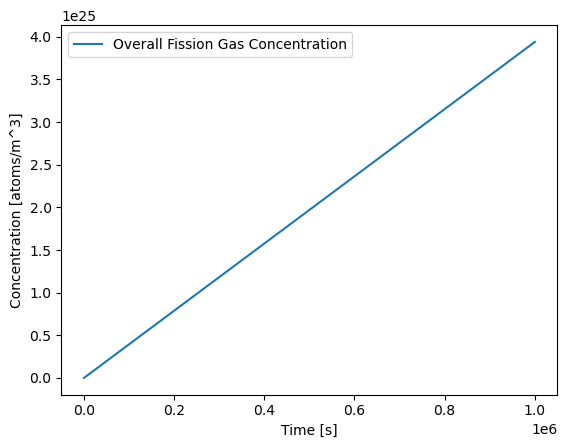

In [112]:
# convert the sympy expression to numerical function
P_lambda = sp.lambdify(t, P_final.rhs, 'numpy')

# plot the results
t_vals = np.linspace(0, 1e6, 100)
P_vals = P_lambda(t_vals)

plt.plot(t_vals, P_vals, label='Overall Fission Gas Concentration')
plt.xlabel('Time [s]')
plt.ylabel('Concentration [atoms/m^3]')
plt.legend()
plt.show()

In [113]:
display('Solution for G_M:')
## boundary conditions for GM 
boundary_outer = sp.Eq(symGM.subs(r, a), 0)   # Boundary at r = a
boundary_symmetry = sp.Eq(symGM.diff(r).subs(r, 0), 0)  # Symmetry Boundary Condition

# display the boundary conditions
display('Boundary Condition at grain surface:', boundary_outer)
display('Symmetry Boundary Condition:', boundary_symmetry)

# initial condition for GM
icGM = {symGM.subs(t, 0): 0}
display('Initial condition for GM:', icGM)

# waiting to solve the equation with initial conditions and boundary conditions, try to check steady state solution
display('We are just interested in the steady state solution for G_M:')
symGM_steady = sp.Function('G_M')(r)
eq_steady = sp.Eq(D_eff * (symGM_steady.diff(r, r) + (1/r) * symGM_steady.diff(r) ) + (f_yield * f_Rate), 0)
GM_steady = sp.dsolve(eq_steady, ics={symGM_steady.subs(r, a): 0, symGM_steady.diff(r).subs(r, 0): 0})

display(eq_steady)
display('The steady state solution for G_M is:', GM_steady)

GM_radial_steady = GM_steady.subs({
    D_eff: diffusivity_coeff,
    f_yield: FP_yield,
    f_Rate: avg_fission_rate,
})

display('By substituting known values:', GM_radial_steady)

'Solution for G_M:'

'Boundary Condition at grain surface:'

Eq(G_M(1.0e-5, t), 0)

'Symmetry Boundary Condition:'

Eq(Subs(Derivative(G_M(r, t), r), r, 0), 0)

'Initial condition for GM:'

{G_M(r, 0): 0}

'We are just interested in the steady state solution for G_M:'

Eq(D_eff*(Derivative(G_M(r), (r, 2)) + Derivative(G_M(r), r)/r) + f_yield*fission_rate, 0)

'The steady state solution for G_M is:'

Eq(G_M(r), -f_yield*fission_rate*r**2/(4*D_eff) + 2.5e-11*f_yield*fission_rate/D_eff)

'By substituting known values:'

Eq(G_M(r), 5.4641292057388e+23 - 5.46412920573881e+33*r**2)

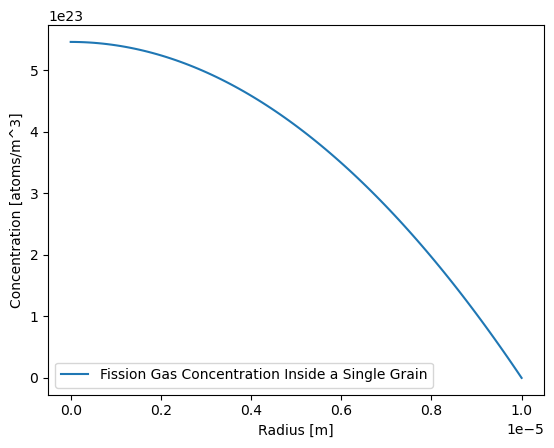

In [114]:
# plot the results of GM steady state solution radially
r_vals = np.linspace(0, a, 100)
GM_vals = [GM_radial_steady.rhs.subs(r, r_val) for r_val in r_vals]

plt.plot(r_vals, GM_vals, label='Fission Gas Concentration Inside a Single Grain')
plt.xlabel('Radius [m]')
plt.ylabel('Concentration [atoms/m^3]')
plt.legend()
plt.show()

In [115]:
### integrate the solution for GM in the radial direction
GM_final = GM_radial_steady.rhs.integrate((r, 0, a)) # found the steady state value for total gas inside the grain 

## compute the amount of gas released in plenum after 1 year

# production of fission gas in the fuel
time = 360 * 24 * 3600 # 1 year (of operation) in seconds
total_fission_gas = P_lambda(time) # total amount of fission gas produced

# total amount of fission gas inside the grains
n_grains_pellet = 1e5 # number of grains in a pellet
n_pellets_pin = round(850e-3/Geometrical_Data.fuel_pellet_height) # number of pellets in a pin
total_fission_gas_grains = GM_final * n_grains_pellet * n_pellets_pin

# total amount of fission gas released in the plenum
total_fission_gas_released = total_fission_gas - total_fission_gas_grains

display('The total fission gas produced in fuel cycle is:')
display(Math(r'P_{\text{total}} =' + f'{total_fission_gas:.2e}' + r'\text{ atoms/m}^3'))
display('The total fission gas remaining inside the grains is:')
display(Math(r'G_{\text{total}} =' + f'{total_fission_gas_grains:.2e}' + r'\text{ atoms/m}^3'))
display('The total fission gas released in the plenum is:')
display(Math(r'FG_{\text{released}} =' + f'{total_fission_gas_released:.2e}' + r'\text{ atoms/m}^3'))

'The total fission gas produced in fuel cycle is:'

<IPython.core.display.Math object>

'The total fission gas remaining inside the grains is:'

<IPython.core.display.Math object>

'The total fission gas released in the plenum is:'

<IPython.core.display.Math object>

#### To consider in the loop implementation

- Effect 1: FGR increases FGR due to k_gap reduction
let's compute the variation in k_gap, subsequent increase in T_fuel_out and so the further increase in fission gas production
this process is then stabilized by thermal expansion of the fuel and cladding --> closes gap 

- Effect 2: Swelling due to the gas trapped in the grains
let's impose a limit: we do not want the gap to be closed

Now plotting the pressure as a function of the plenum height

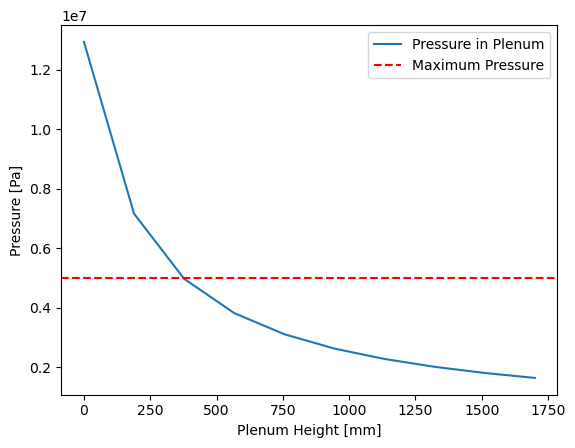

In [116]:
# vector of possible plenum heights
fuel_column_height = 850e-3 # m
h_vals_plenum = np.linspace(0, 2*fuel_column_height, 10)
# display(h_vals_plenum)

# corresponding volume to accomodate gases
V_plenum = (np.pi * r_cladding_gap**2 * h_vals_plenum) + (np.pi * (r_cladding_gap**2 - r_gap_fuel**2) * fuel_column_height)
# display(V_plenum)

# find initial quantity of He present in the plenum
initial_moles_he = vars.p_gas * V_plenum / (8.314 * (vars.T_gas + 273.15)) # moles
# display(initial_moles_he)

# find the additional moles of fission gases released in the plenum
V_pin = np.pi * (Geometrical_Data.fuel_outer_diameter/2)**2 * fuel_column_height # m^3
additional_moles_fg = (total_fission_gas_released * V_pin) / 6.022e23 # moles
# display(additional_moles_fg)

# find the total moles of gases in the plenum
total_moles_gas = initial_moles_he + additional_moles_fg # moles
# display(total_moles_gas)

# find the new pressure in the plenum
new_p_gas = total_moles_gas * 8.314 * (vars.T_gas + 273.15) / V_plenum # Pa
# display(new_p_gas)

# new pressure in plenum as a function of plenum height
plt.plot(h_vals_plenum * 1e3, new_p_gas, label='Pressure in Plenum')
plt.xlabel('Plenum Height [mm]')
plt.ylabel('Pressure [Pa]')
plt.legend()

# add a limit line for maximum allowed pressure at 5 MPa
plt.axhline(y=5e6, color='r', linestyle='--', label='Maximum Pressure')
plt.legend()
plt.show()

Testing the implementation of the function

In [117]:
h_plenum = 1  # m
He_percentage, Gas_Pressure = f.fission_gas_production(h_plenum, Fuel_Proprieties, ThermoHydraulics, Geometrical_Data, vars.T_map)
display(Math(r'\text{He Percentage} =' + f'{He_percentage:.2f}' + r'\%'))
display(Math(r'\text{Gas Pressure} =' + f'{Gas_Pressure*1e-6:.2f}' + r'\text{ MPa}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>